In [1]:
from functions import *

## Load in standardized data

In [2]:
file_df = pd.read_csv(f'data/mer_taffc_split.csv')

In [6]:
n_segs = 2696
dur = '10s'

In [7]:
max_pct_zero = 0.5
paths = file_df['path'].tolist()
qs    = file_df['quadrant']
test  = file_df['test']
val   = file_df['validation']
for i, path in enumerate(paths):
    split = path.split('\\')
    folder = f'MER_taffc_standard_{dur}'
    split[1] = folder
    split[-1] = split[-1][:-4] + '-*'
    paths[i] = '\\'.join(split)
X = np.zeros((n_segs, mels, ts, 1))
y = np.zeros((n_segs, 4))
ids = []
test_val_train = np.zeros((n_segs, 3), dtype=bool)
j = 0 # file counter
for i in tqdm(range(len(paths))):
    files = glob(paths[i])
    for file in files:
        seg, sr = lb.load(file)
        n = seg.shape[0]
        if (seg == 0).sum()/n <= max_pct_zero:
            db_norm, mean, std = audio_to_feat(seg)
            X[j, :, :, 0] = db_norm
            q = qs[i]
            if q == 'Q1':
                target = [1, 0, 0, 0]
            elif q == 'Q2':
                target = [0, 1, 0, 0]
            elif q == 'Q3':
                target = [0, 0, 1, 0]
            else:
                target = [0, 0, 0, 1]
            y[j, :] = target
            test_val_train[j, 0] = test[i]
            test_val_train[j, 1] = val[i]
            test_val_train[j, 2] = 1 - max(test[i], val[i])
            ids.append(file)
            j += 1
X = X[:j, :, :, :]
y = y[:j, :]
test_val_train = test_val_train[:j, :]
print(f'number of clips: {n_segs}')
y.sum(axis=0)

  0%|          | 0/900 [00:00<?, ?it/s]

number of clips: 2696


array([671., 675., 675., 675.])

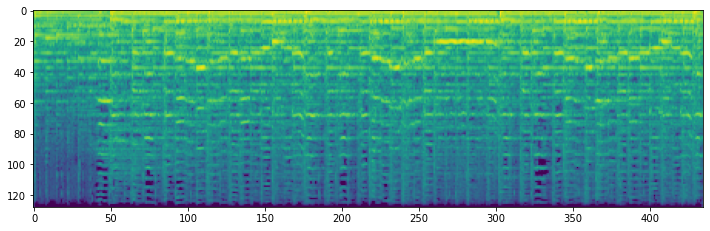

In [12]:
plt.figure(figsize=(12,12))
plt.imshow(X[10, :, :, :])
plt.show()

## Model

In [8]:
lrelu = keras.layers.LeakyReLU(alpha=0.01)
l2 = L2(l2=0.001)
model = get_mer(lrelu, l2)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 435, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 435, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 217, 64)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 217, 64)       36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 217, 64)       36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 108, 64)      0         
 2D)                                                    

In [15]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

## Train/test/val split

In [9]:
ids = np.array(ids)

In [10]:
X_train = X[test_val_train[:, 2], :, :, :]
X_val   = X[test_val_train[:, 1], :, :, :]
X_test  = X[test_val_train[:, 0], :, :, :]

y_train = y[test_val_train[:, 2], :]
y_val   = y[test_val_train[:, 1], :]
y_test  = y[test_val_train[:, 0], :]

train_id = ids[test_val_train[:, 2]]
val_id   = ids[test_val_train[:, 1]]
test_id  = ids[test_val_train[:, 0]]

In [21]:
# TRAINING: do on GPU
# callback = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=4, restore_best_weights=True)
# history = model.fit(
#     x=X_train,
#     y=y_train,
#     epochs=1,
#     batch_size=64,
#     callbacks=[callback],
#     validation_data=(X_val, y_val)
# )

31/31 [==============================] - 967s 30s/step - loss: 1.7961 - categorical_accuracy: 0.2441 - val_loss: 1.6874 - val_categorical_accuracy: 0.2523


## Load in trained model

In [7]:
model_paths = [
    'mer_models/mer_model_2_7_23.h5',
    'mer_models/mer_model_2023_02_09_v0.h5',
    'mer_models/mer_model_2023_02_09_v4.h5',
    'mer_models/mer_model_2023_02_09_v5.h5',
    'mer_models/mer_model_2023_02_09_v6.h5',
    'mer_models/mer_model_2023_02_12_v7.h5'
]

In [8]:
n = y_test.shape[0]
for path in model_paths:
    model = keras.models.load_model(path)
    test_pred = model.predict(X_test, verbose=0)
    m = keras.metrics.CategoricalAccuracy()
    m.update_state(y_test, test_pred)
    acc = m.result().numpy()*100
    
    y_test_class = [np.argmax(y_test[i, :]) for i in range(n)]
    test_pred_class = [np.argmax(test_pred[i, :]) for i in range(n)]
    
    print(path[:-3] + ':')
    print(f'Test accuracy = {acc}%')
    print(f'Confusion matrix =\n{confusion_matrix(y_test_class, test_pred_class)}\n')

mer_models/mer_model_2_7_23:
Test accuracy = 59.81481671333313%
Confusion matrix =
[[112   6   5  12]
 [ 45  83   4   3]
 [ 29   8  37  61]
 [ 23   5  16  91]]

mer_models/mer_model_2023_02_09_v0:
Test accuracy = 56.48148059844971%
Confusion matrix =
[[95 29 11  0]
 [33 96  4  2]
 [31 12 53 39]
 [21  3 50 61]]

mer_models/mer_model_2023_02_09_v4:
Test accuracy = 58.14814567565918%
Confusion matrix =
[[ 81  27  20   7]
 [ 19 111   0   5]
 [ 12  18  22  83]
 [  9  12  14 100]]

mer_models/mer_model_2023_02_09_v5:
Test accuracy = 52.40740776062012%
Confusion matrix =
[[100   2  33   0]
 [ 43  80  12   0]
 [ 27   6 102   0]
 [ 15   4 115   1]]

mer_models/mer_model_2023_02_09_v6:
Test accuracy = 62.59258985519409%
Confusion matrix =
[[113  11  11   0]
 [ 28  97   5   5]
 [ 18  10  32  75]
 [ 19   7  13  96]]

mer_models/mer_model_2023_02_12_v7:
Test accuracy = 60.00000238418579%
Confusion matrix =
[[ 98  15  22   0]
 [ 30 100   5   0]
 [ 19  20  81  15]
 [ 13  21  56  45]]



## Best model: `mer_model_2023_02_09_v6.h5`
* `mer_model_2023_02_12_v7.h5` is the same model, trained with `X_train+X_val`

In [11]:
hist_paths = [
    'mer_models/history_2023_02_09_v0.csv',
    'mer_models/history_2023_02_09_v4.csv',
    'mer_models/history_2023_02_09_v5.csv',
    'mer_models/history_2023_02_09_v6.csv'
]

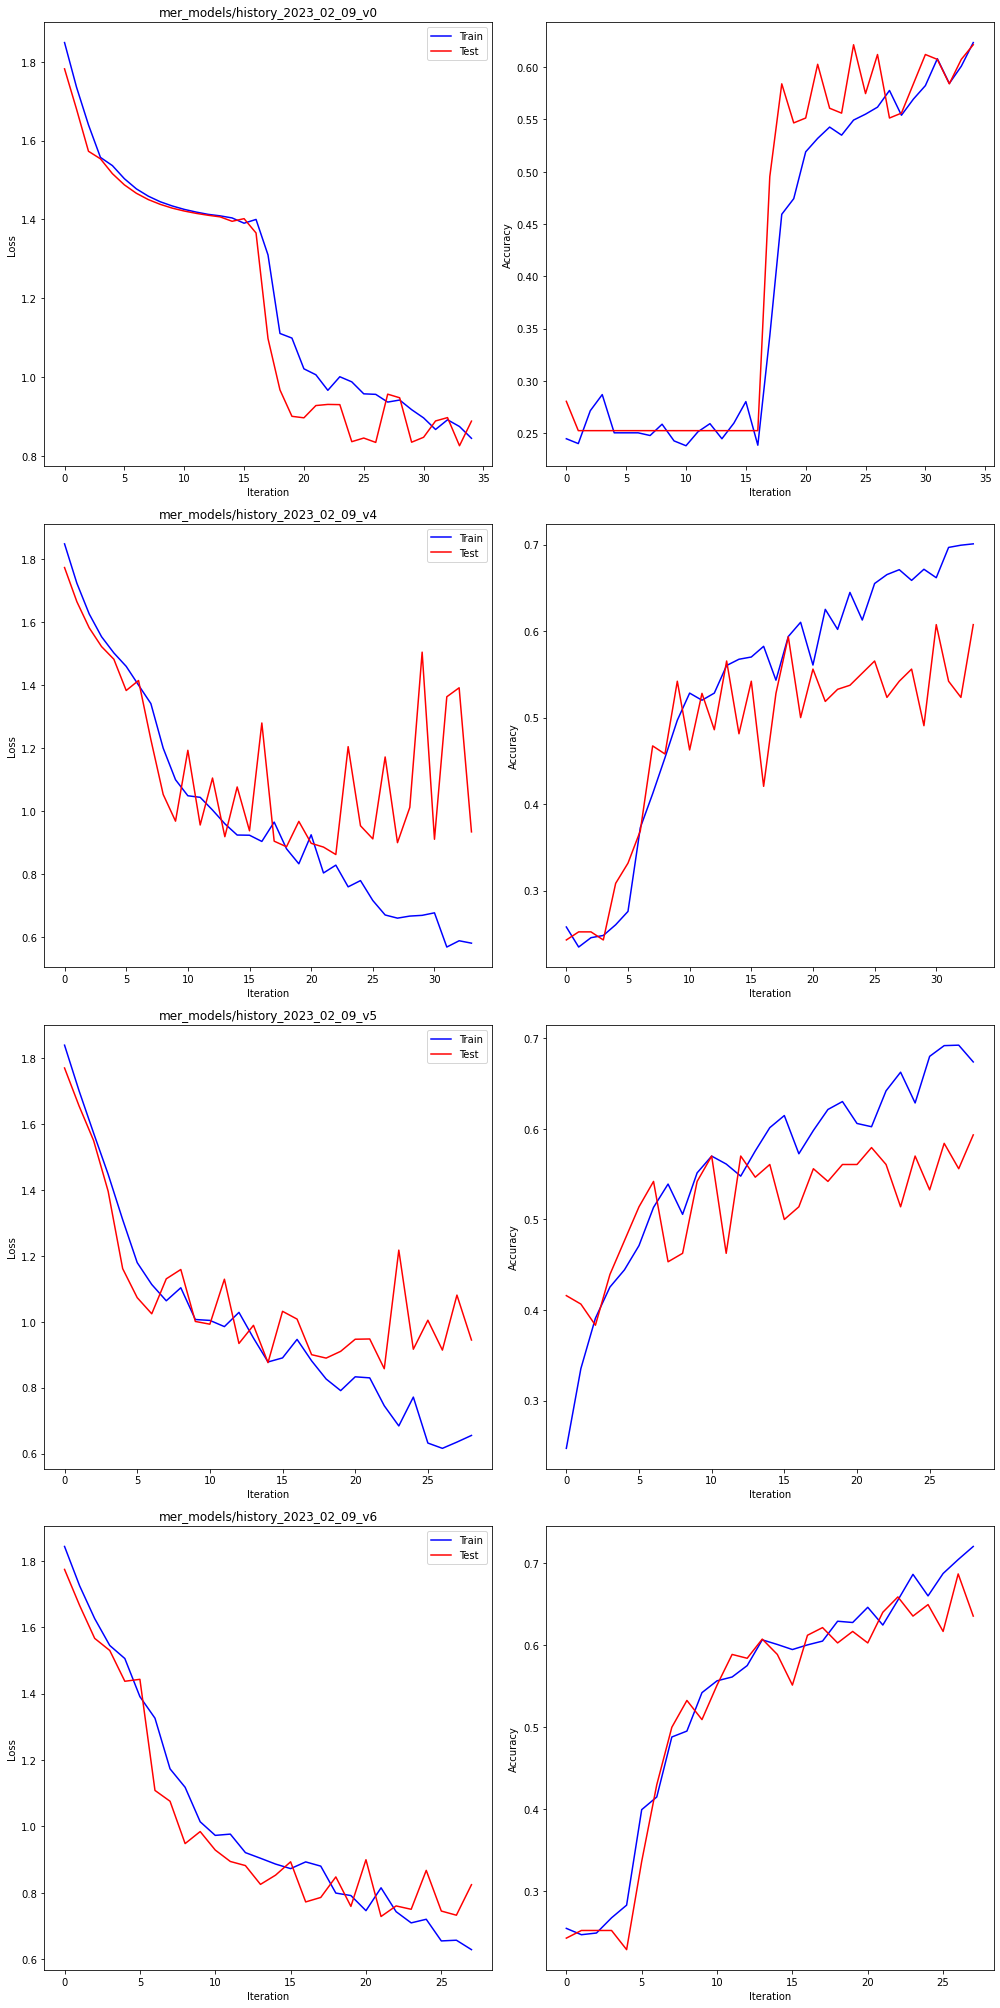

In [12]:
m = len(hist_paths)
fig, axs = plt.subplots(nrows=m, ncols=2, figsize=(14, 7*m))
for i, path in enumerate(hist_paths):
    df = pd.read_csv(path)
    its = df.index
    loss = df['loss']
    val_loss = df['val_loss']
    
    acc = df['categorical_accuracy']
    val_acc = df['val_categorical_accuracy']
    
    axs[i, 0].plot(its, loss, c='blue')
    axs[i, 0].plot(its, val_loss, c='red')
    axs[i, 0].set_xlabel('Iteration')
    axs[i, 0].set_ylabel('Loss')
    axs[i, 0].set_title(path[:-4])
    axs[i, 0].legend(['Train', 'Test'])
    
    axs[i, 1].plot(its, acc, c='blue')
    axs[i, 1].plot(its, val_acc, c='red')
    axs[i, 1].set_xlabel('Iteration')
    axs[i, 1].set_ylabel('Accuracy')    
plt.tight_layout()